# Задача 5. Обучение без учителя

### Задача

1. Найти данные с количеством признаков хотя бы 50, на которых можно решить
задачу кластеризации.
2. Выполнить разведочный анализ (EDA). При необходимости выполнить полезные преобразования данных.
3. Самостоятельно реализуйте один из алгоритмов кластеризации, например K-means.
4. Обучите модели кластеризации, используя свою реализацию, а также хотя бы две реализации из sklearn (KMeans, Affinity Propogation, DBSCAN и тд).
При обучении использовать подбор гиперпараметров.
5. Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества.

6. (+3 балла) Также снизить размерность данных с помощью метода главных компонент PCA и и понять качество дальнейшей кластеризации всеми использованными реализациями при различном количестве главных компонент.
7. (+2 балла) Визуализировать данные снижением размерности до 2 или 3 с помощью PCA и t-SNE. В случае проблем с производительностью t-SNE, можно сначала до какой то степени снизить размерность с помощью PCA, а затем запустить t-SNE.

In [71]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

## 1. Датасет


Для задачи возьмем датасет с Kaggle c 96 числом признаков [Company Bankruptcy Prediction](https://www.kaggle.com/datasets/fedesoriano/company-bankruptcy-prediction). Данные в датасете были собраны из Taiwan Economic Journal за 1999–2009 годы, отражающие банкротство компаний на основе правил ведения бизнеса Тайваньской фондовой биржи.

In [72]:
df = pd.read_csv("/content/data.csv")
df = df.sample(frac=1).reset_index(drop=True)

In [73]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0,0.594745,0.653674,0.657048,0.655977,0.655977,0.999346,0.797861,0.809759,0.303559,...,0.861468,0.000719,0.624035,0.655973,0.843373,0.275398,0.026791,0.565158,1,0.145288
1,0,0.520938,0.589130,0.574763,0.602891,0.602927,0.999037,0.797490,0.809403,0.303558,...,0.827132,0.001605,0.623902,0.602893,0.842407,0.279005,0.026799,0.565196,1,0.032620
2,0,0.490128,0.553751,0.536645,0.598373,0.598373,0.998995,0.797411,0.809328,0.303509,...,0.807528,0.001236,0.623896,0.598369,0.841940,0.291699,0.026972,0.565893,1,0.015920
3,0,0.512456,0.570868,0.553670,0.598827,0.599043,0.999012,0.797442,0.809348,0.303525,...,0.820670,0.000891,0.624302,0.598827,0.841951,0.279202,0.026862,0.565477,1,0.031643
4,0,0.591040,0.639392,0.620108,0.602711,0.602711,0.999059,0.797928,0.809693,0.304277,...,0.852241,0.000846,0.625048,0.602710,0.843441,0.276774,0.026802,0.565210,1,0.056490


## 2. EDA

In [74]:
df.shape

(6819, 96)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [76]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [77]:
[print(col) for col in df if df[col].isna().sum() > 0]

[]

Можно заметить, что NULL-ов в данных нет. Проверим на дубликаты

In [78]:
df.duplicated().sum()

0

Дубликатов тоже в данных нет

In [79]:
print(df['Bankrupt?'].value_counts())

Bankrupt?
0    6599
1     220
Name: count, dtype: int64


Можно заметить, что данные не сбалансированы.


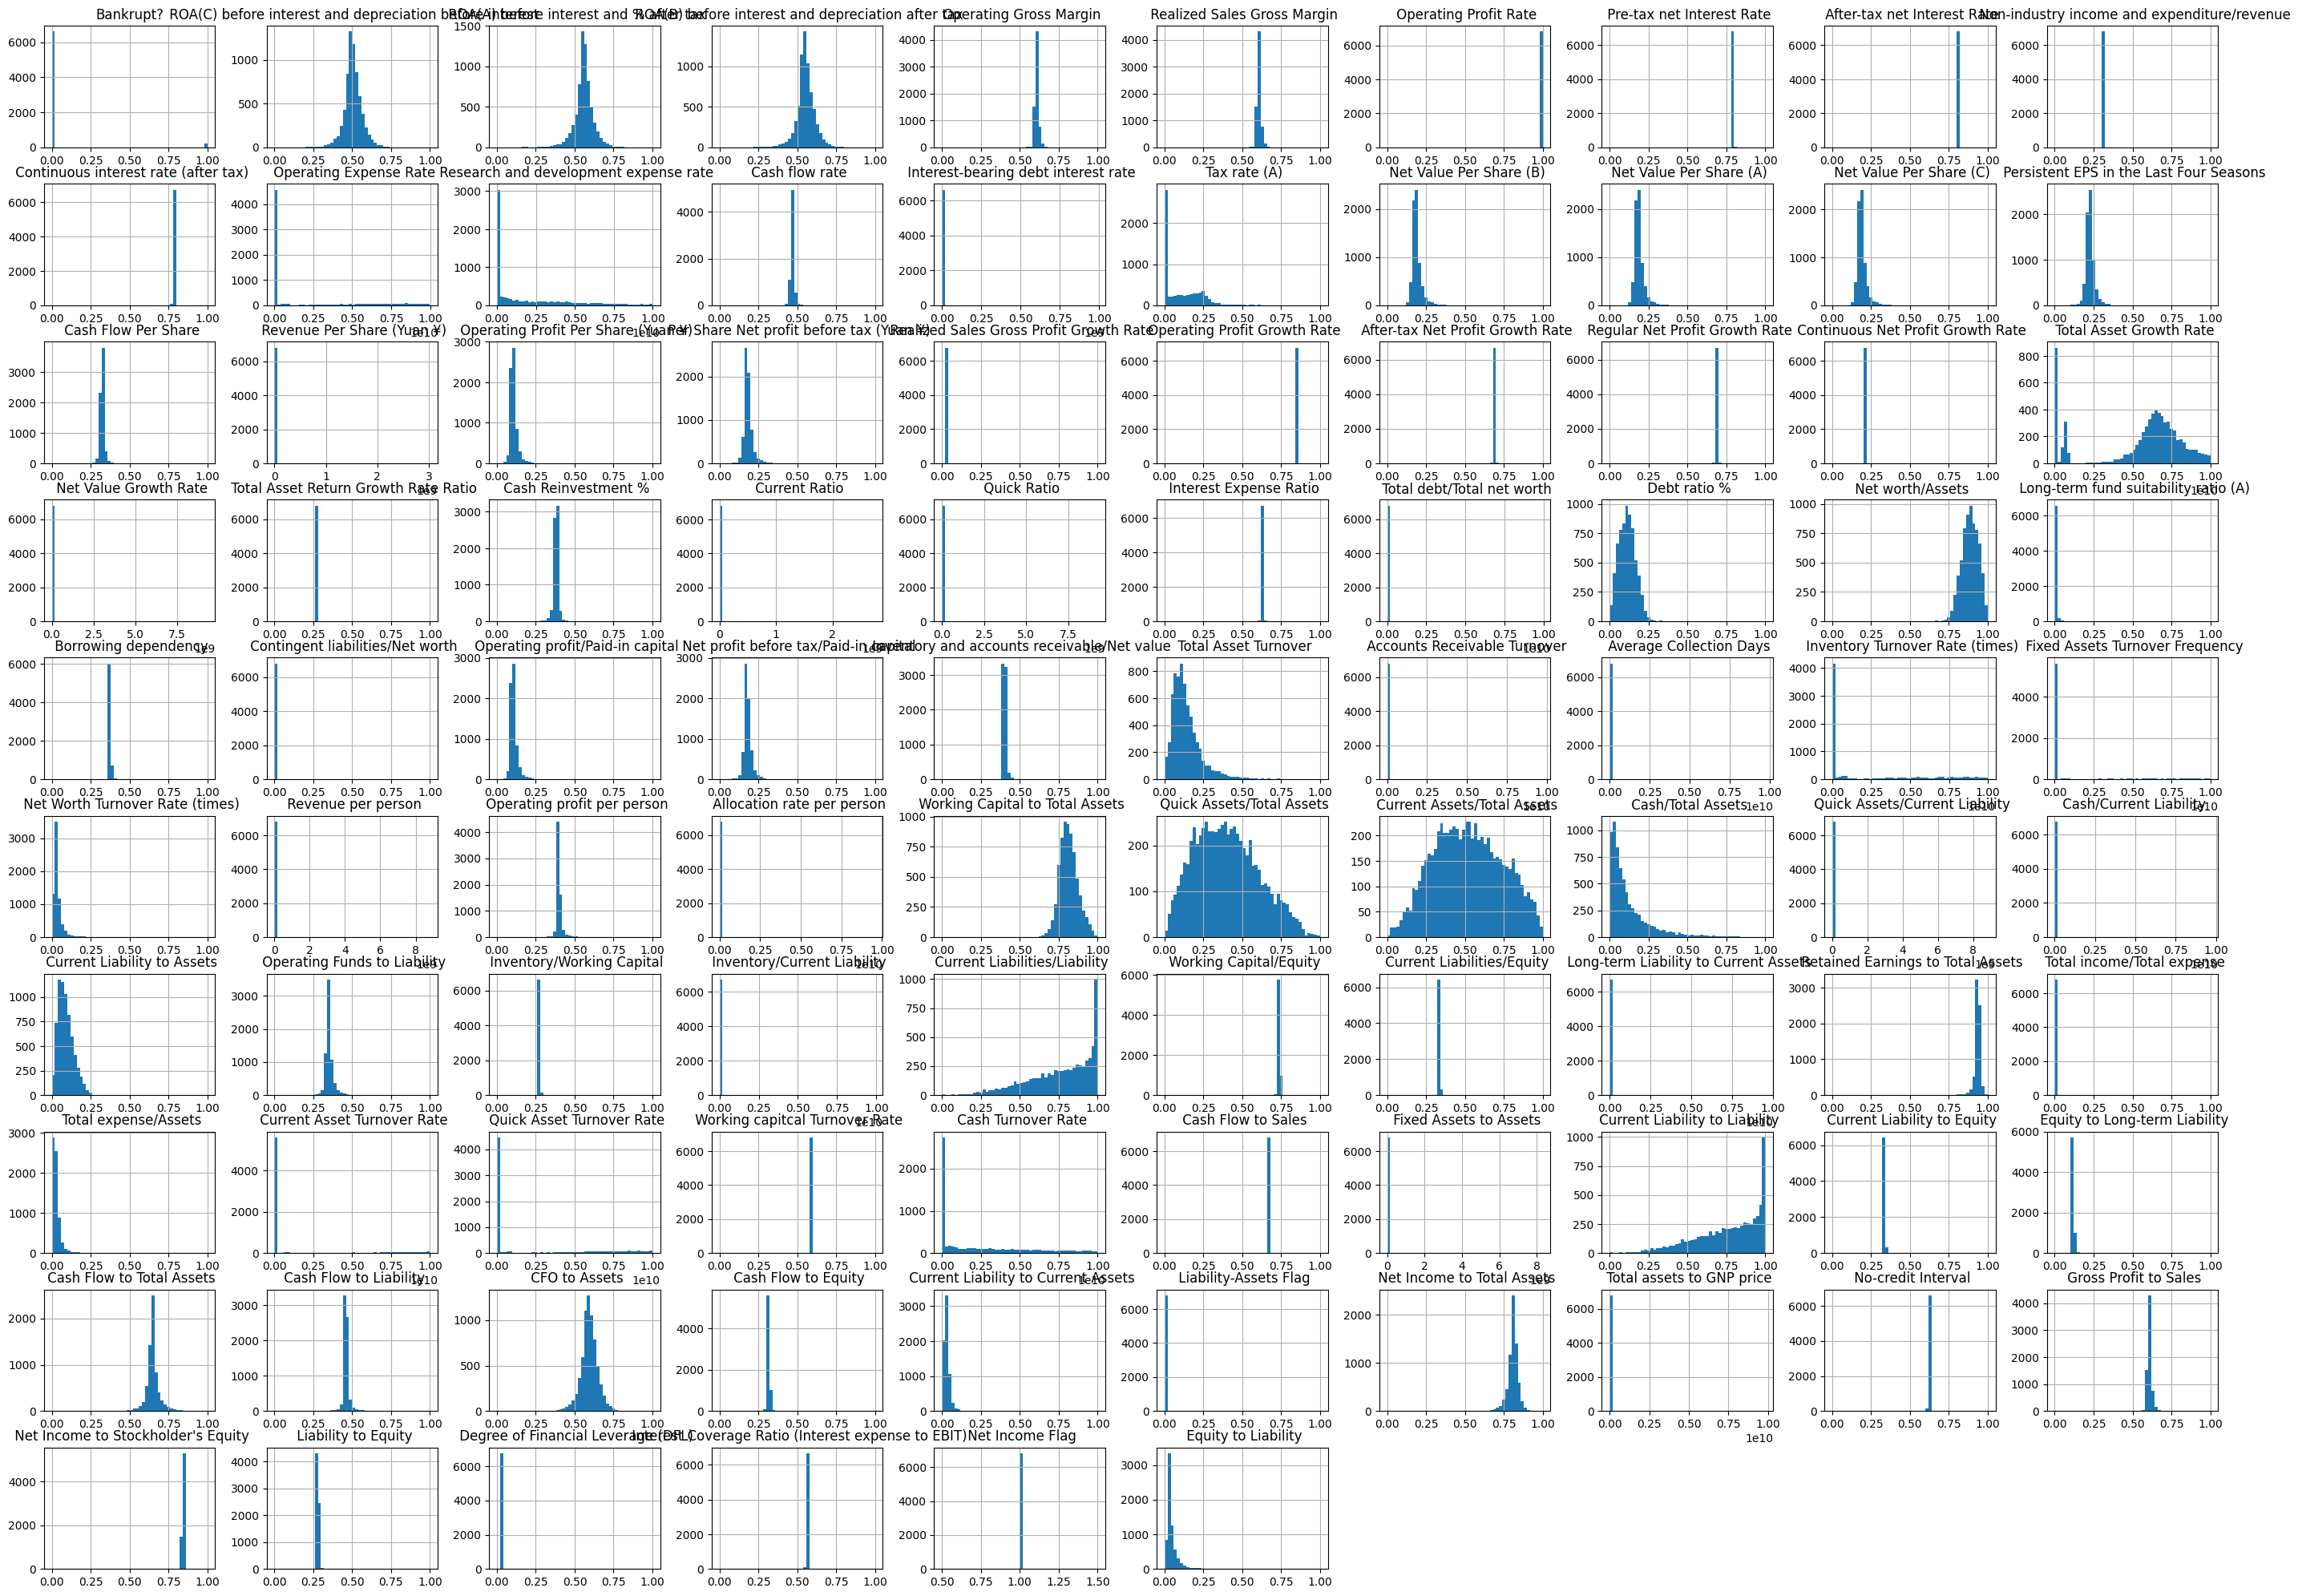

In [83]:
df.hist(figsize = (35,25), bins = 50)
plt.show()

Посмотрим на корреляцию признаков

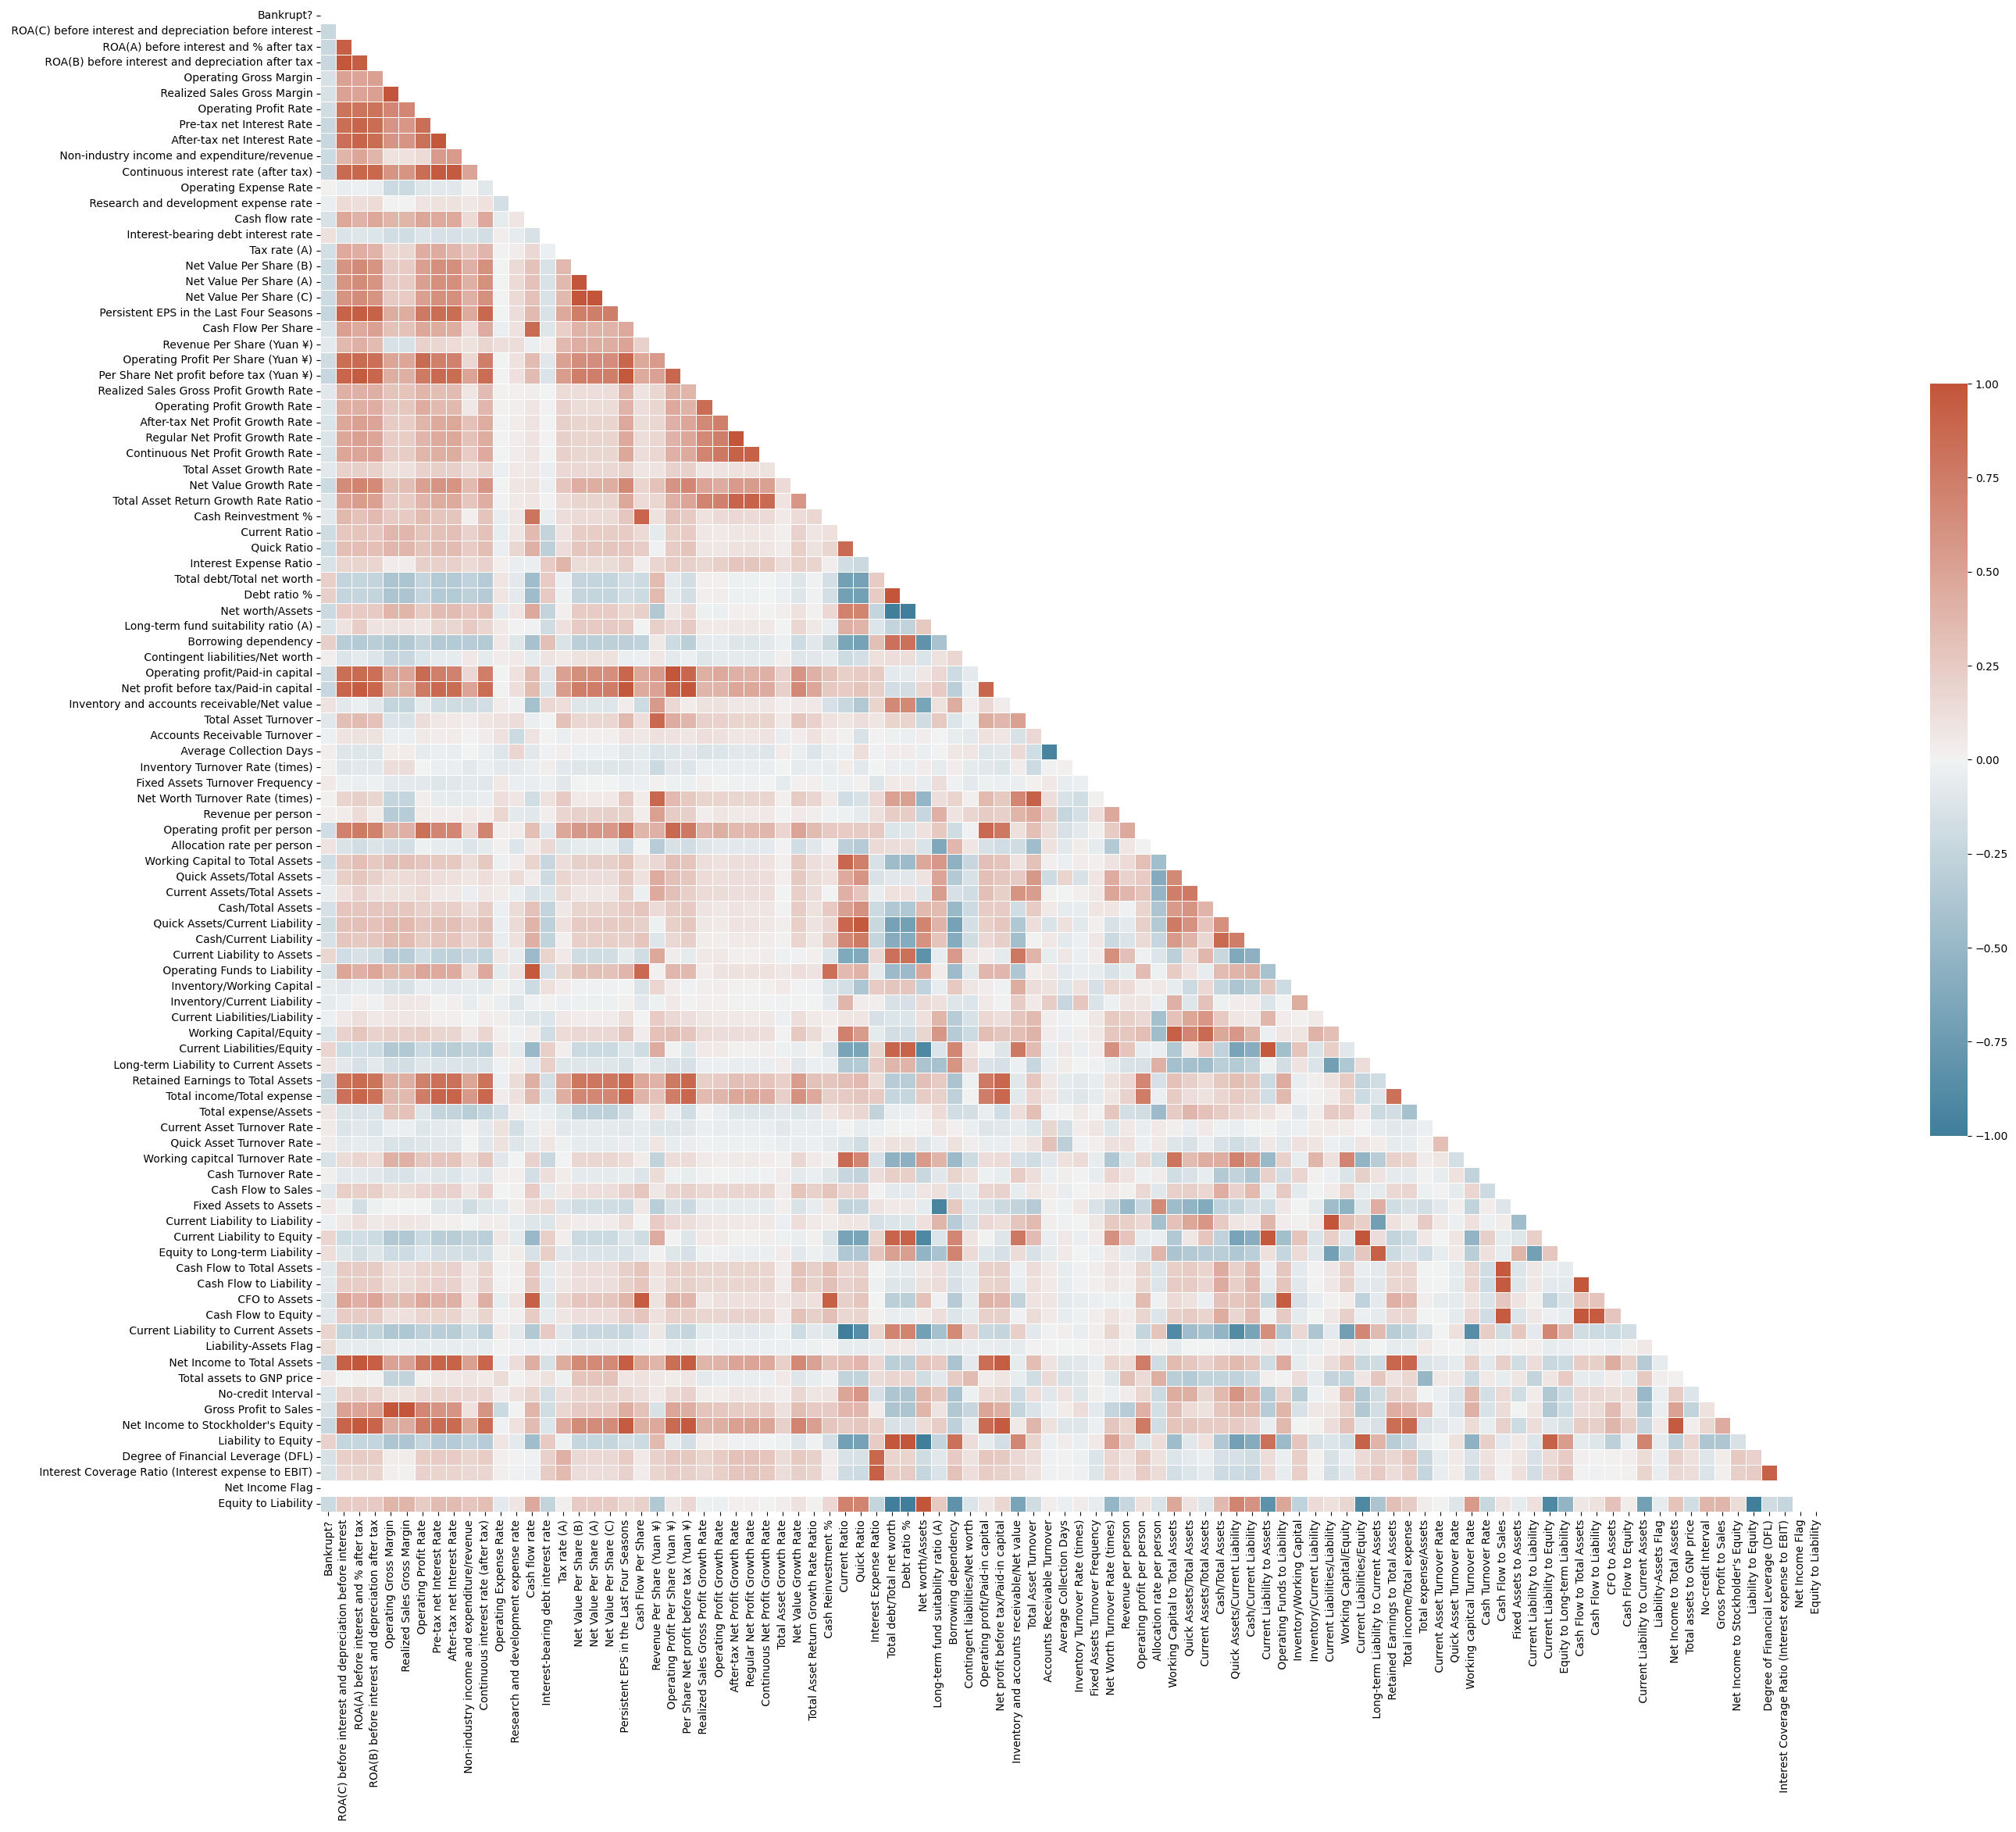

In [82]:
f, ax = plt.subplots(figsize=(35, 25))
mat = df.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Посмотрим на выбросы

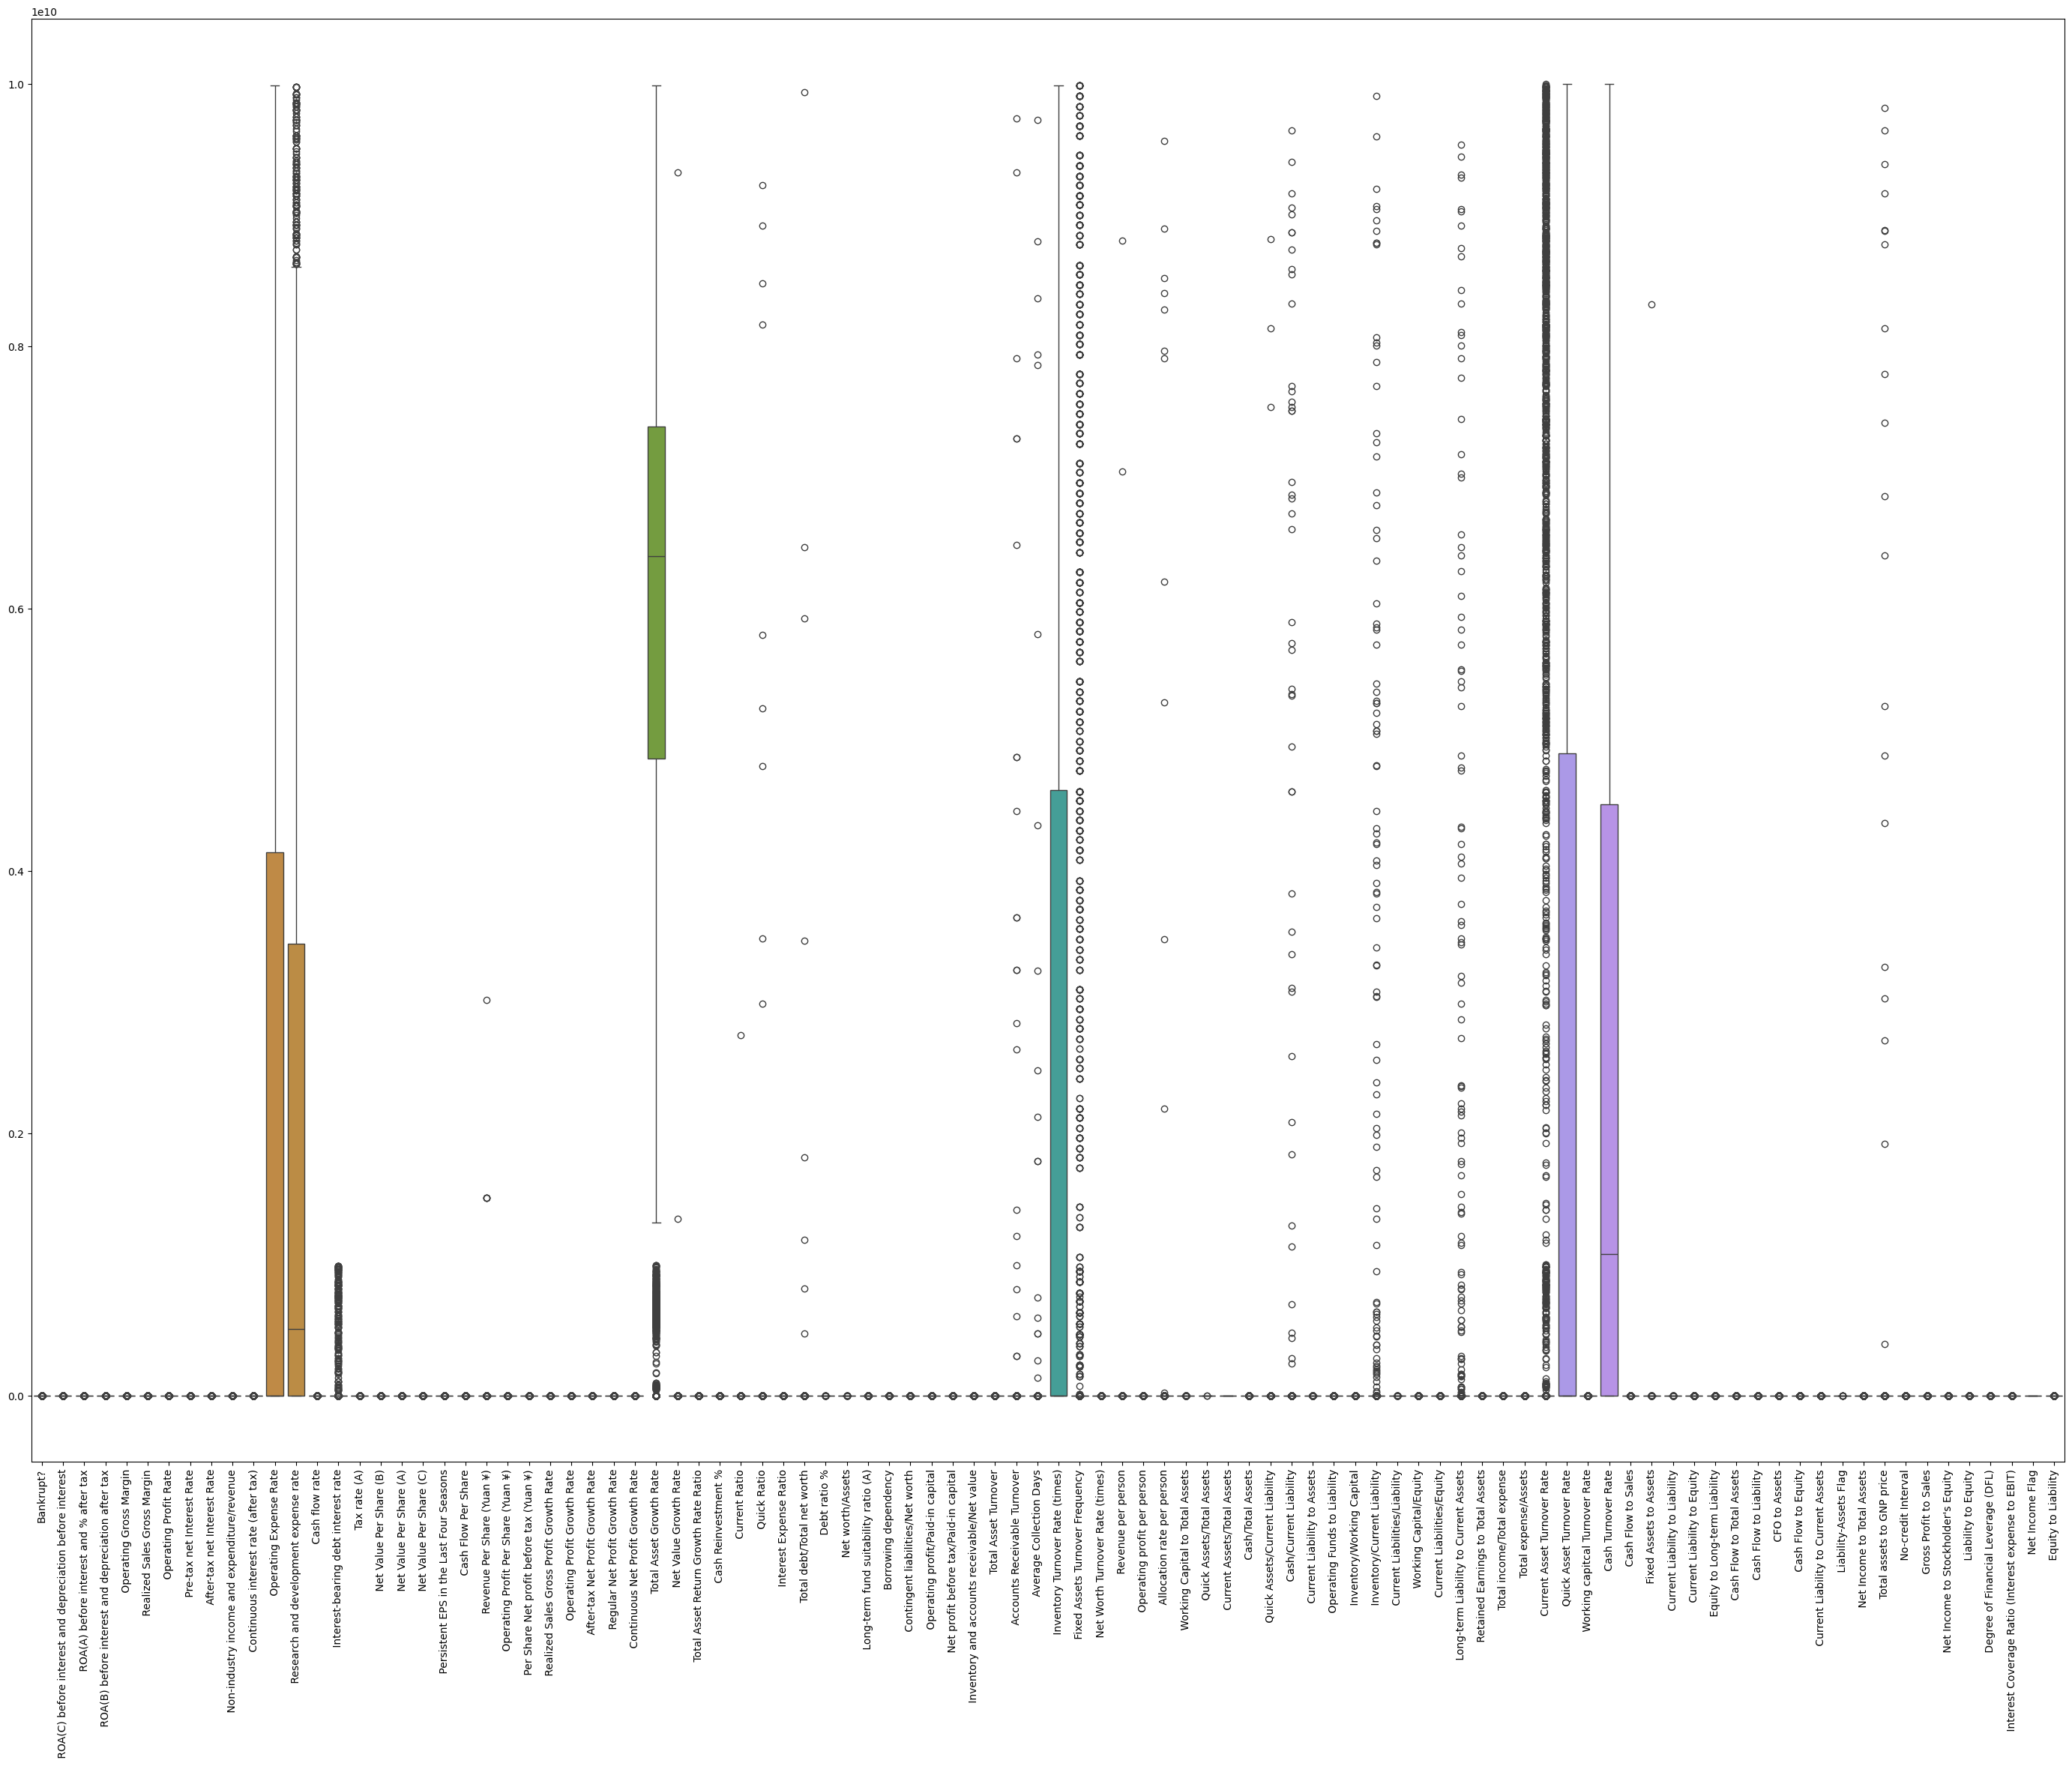

In [84]:
plt.figure(figsize=(35, 25))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.show()

## Самостоятельная реализация алгоритма кластеризации K-means

In [100]:
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

In [101]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X):
        X = X.to_numpy()
        self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

        for _ in range(self.max_iter):
            distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
            self.labels = np.argmin(distances, axis=0)

            new_centroids = np.array([X[self.labels == k].mean(axis=0) for k in range(self.n_clusters)])

            if np.allclose(self.centroids, new_centroids):
                break
            self.centroids = new_centroids

    def predict(self, X):
        distances = np.sqrt(((X - self.centroids[:, np.newaxis])**2).sum(axis=2))
        return np.argmin(distances, axis=0)

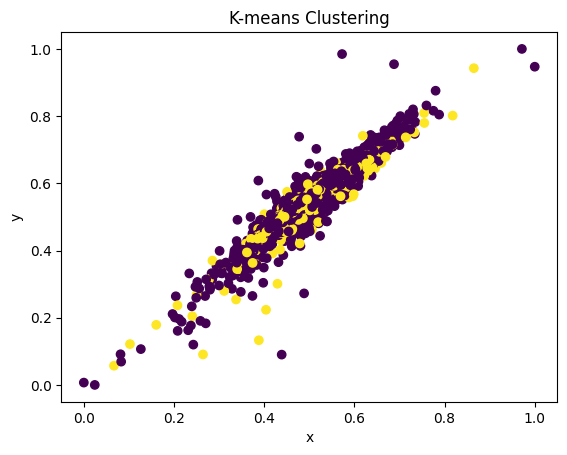

In [102]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

labels = kmeans.predict(X)

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-means Clustering')
plt.show()

Из графика ничего не понятно, применим PCA

## PCA

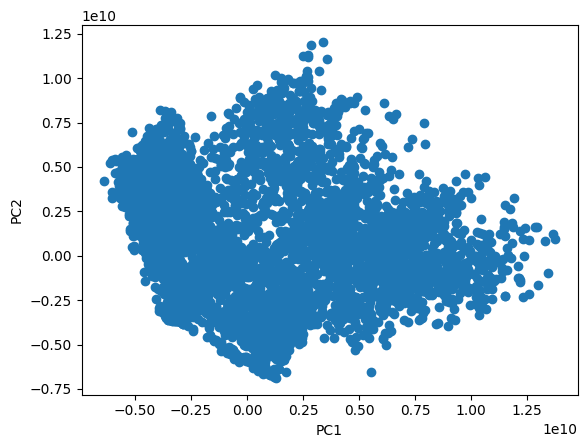

In [103]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(X)

plt.scatter(data_pca[:, 0], data_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

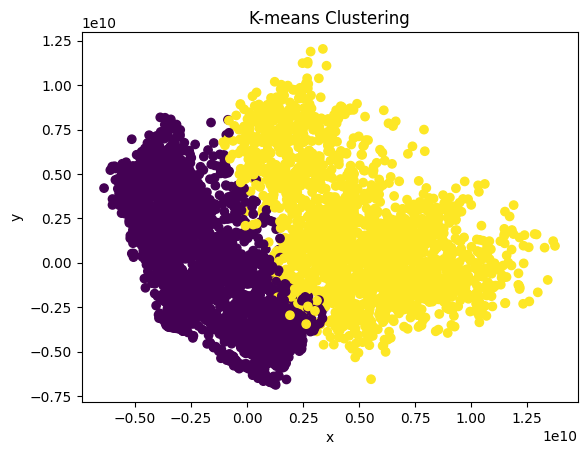

In [104]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('x')
plt.ylabel('y')
plt.title('K-means Clustering')
plt.show()

Теперь на графике есть два ярко выраженных кластера

## KMeans из бибилиотеки sklearn

In [107]:
from sklearn.cluster import KMeans

In [108]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

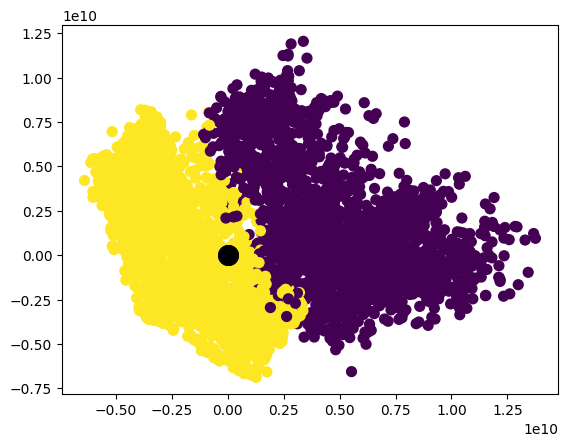

In [110]:
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200);

## Перебор с гиперпараметрами

In [105]:
models = ['CustomKMeans', 'KMeans', 'AffinityPropagation']

In [ ]:
# 4. KMeans из sklearn с подбором гиперпараметров
param_grid_kmeans = {
    'n_clusters': range(2, 6),
}